In [7]:
# import libraries 
import numpy as np 
import pandas as pd 
import tensorflow as tf

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif, f_classif, SelectPercentile
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from skimage import io, color
from skimage.feature import local_binary_pattern, hog
from skimage.feature import canny
from skimage.filters import sobel, sobel_h, sobel_v
from scipy.stats import entropy

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
# calculate average size to help inform a size to resize all images to
imagex = 0
imagey = 0
for i in range(1, 5489):    
    image = Image.open(f'Data/train/img_00{i:04d}.jpg')
    imagex += image.size[0]
    imagey += image.size[1]
    
print(imagex/5488) # 50.567237609329446
print(imagey/5488) # 50.05648688046647

# scale to 50 x 50
rescale_size = (50, 50)

50.567237609329446
50.05648688046647


In [2]:
# import paths and labels
train_metadata = pd.read_csv("Data/train/train_metadata.csv", index_col="id")
train_paths = train_metadata["image_path"]
train_class = train_metadata["ClassId"]

# import test set
test_metadata = pd.read_csv("Data/test/test_metadata.csv")
test_paths = test_metadata["image_path"]
test_index = test_metadata["id"]

rescale_size = (50, 50)

# Feature Extraction

In [36]:
### HOG

In [43]:
def extract_hog(source: str, rescale_size=(50,50)):
    if source == "train":
        all_images = train_paths
    else:
        all_images = test_paths

    hog_data = []
    hog_images = []

    for path in all_images:
        # Load and resize image
        image = Image.open(f"Data/{source}/{path}")
        image_array = image.resize(rescale_size)
        gray_image = color.rgb2gray(image_array)

        features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        
        hog_data.append(features.astype(np.float32)) 
        hog_images.append(path)

    # Create DataFrame
    hist_df = pd.DataFrame(hog_data)
    hist_df.insert(0, 'image_path', hog_images)
    
    if source == "train":
        hist_df.index = train_metadata.index
    else:
        hist_df.index = test_metadata.index
    # save data into a csv file
    # hist_df.to_csv(f"Data/{source}/Features/hog.csv", index=False)

    return hist_df

train_hog = extract_hog("train")

### LBP

c:\Users\rayzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


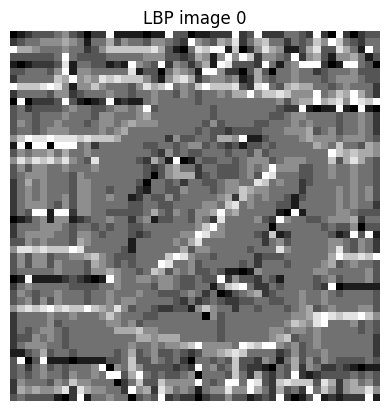

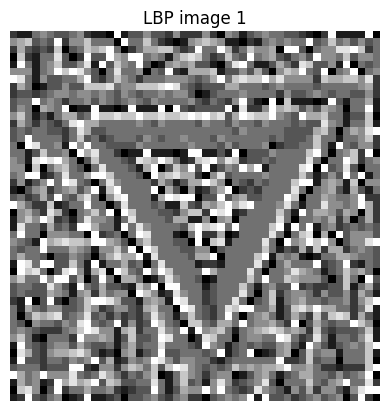

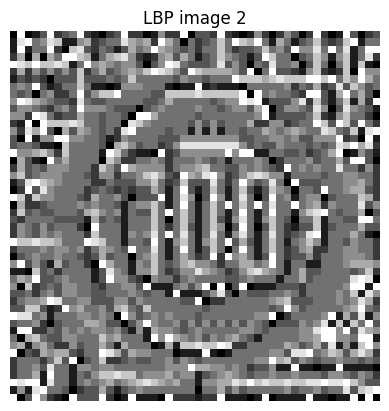

In [45]:
# hyperparameters
r = 1
points = r * 8
method = 'uniform'

def extract_lbp(source: str):
    # extract image paths

    if source == "train":
        all_images = train_metadata["image_path"]
    else:
        all_images = test_metadata["image_path"]
    
    lbp_data = []
    lbp_images = []
    lbp_images_raw = []

    # extract lbp values
    for path in all_images:
        image = Image.open(f"Data/{source}/{path}")
        image = image.resize(rescale_size)
        gray_image = color.rgb2gray(image)

        lbp = local_binary_pattern(gray_image, points, r, method)

        lbp_images_raw.append(lbp)

        n_bins = int(lbp.max() + 1)
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

        lbp_data.append(hist)
        lbp_images.append(path)


    lbp = pd.DataFrame(lbp_data)
    lbp.insert(0, 'image_path', lbp_images)
    
    if source == "train":
        lbp.index = train_metadata.index
    else:
        lbp.index = test_metadata.index

    for i in range(3):
        plt.imshow(lbp_images_raw[i], cmap='gray')
        plt.title(f"LBP image {i}")
        plt.axis('off')
        plt.show()  

    # lbp.to_csv('lbp.csv', index=False)

    return lbp

lbp_train = extract_lbp("train")

### Canny Edge Detection

In [7]:
# Hyperparameter
SIGMA = 1

def extract_canny(source: str):
    if source == "train":
        all_images = train_metadata["image_path"]
    else:
        all_images = test_metadata["image_path"]

    canny_data = []
    canny_images = []

    for path in all_images:
        image = Image.open(f"Data/{source}/{path}")
        image = image.resize(rescale_size)
        image_array = np.array(image)
        gray_image = color.rgb2gray(image_array)

        edges = canny(gray_image, sigma=SIGMA)

        canny_data.append(edges.astype(np.float32)) 
        canny_images.append(path)

    canny_flat = [edge.flatten() for edge in canny_data]
    canny_flat = pd.DataFrame(canny_flat)
    canny_flat.insert(0, 'image_path', canny_images)
    
    if source == "train":
        canny_flat.index = train_metadata.index
    else:
        canny_flat.index = test_metadata.index

    if False:
        canny_entropy(canny_data)

    # for i in range(3):
    #     plt.imshow(canny_data[i], cmap='gray')
    #     plt.title(f"Canny Edge Detection")
    #     plt.axis('off')
    #     plt.show()    

    return canny_flat

canny_train = extract_canny("train")

In [5]:
# tuning the value of sigma using entropy

def canny_entropy(canny_data):
    entropies = []

    for data in canny_data:
        values, counts = np.unique(data.astype(int), return_counts=True)
        probs = counts / counts.sum() 
        entropies.append(float(entropy(probs, base=2)))

    print(np.mean(entropies)) 
    # sigma = 1: 0.5726
    # sigma = 2: 0.3871
    # sigma = 3: 0.2597

    # choose sigma = 1

In [ ]:
X = canny_train.drop(columns=['image_path']).values  

pca = PCA(n_components=0.75)  # reduce dimensions but keep 75% of the variance
X_pca = pca.fit_transform(X)

print(f"Original shape: {X.shape}")
print(f"Reduced shape: {X_pca.shape}")

canny_df = pd.DataFrame(X_pca, index=canny_train.index)

# Add the image_path column back
canny_df.insert(0, 'image_path', canny_train['image_path'])

canny_df.to_csv('canny.csv', index=False)



Original shape: (2353, 2500)
Reduced shape: (2353, 458)


### Sobel Filtering

In [8]:
def extract_sobel(source: str):

    if source == "train":
        all_images = train_metadata["image_path"]
    else:
        all_images = test_metadata["image_path"]
    
    sobel_data = []
    sobel_images = []

    for path in all_images:
        image = Image.open(f"Data/{source}/{path}")
        image = image.resize(rescale_size)
        image_array = np.array(image)
        gray_image = color.rgb2gray(image_array)

        sobel_edge = sobel(gray_image)

        # sx = sobel_h(gray_image)
        # sy = sobel_v(gray_image)
        # sobel_edge = np.hypot(sx, sy)

        sobel_data.append(sobel_edge.flatten())
        sobel_images.append(path)

    sobel_df = pd.DataFrame(sobel_data)

    
    if source == "train":
        sobel_df.index = train_metadata.index
    else:
        sobel_df.index = test_metadata.index

    # for i in range(3):
    #     sobel_image = sobel_df.iloc[i].values.reshape(rescale_size)
    #     plt.imshow(sobel_image, cmap='gray')
    #     plt.title(f"Sobel Filtering")
    #     plt.axis('off')
    #     plt.show()
        
    sobel_df.insert(0, 'image_path', sobel_images)

    return sobel_df

sobel_train = extract_sobel("train")

In [ ]:
X = sobel_train.drop(columns=["image_path"]).values  

pca = PCA(n_components=0.75)  
X_pca = pca.fit_transform(X)

print(f"Original shape: {X.shape}")
print(f"Reduced shape: {X_pca.shape}")

sobel_df = pd.DataFrame(X_pca, index=sobel_train.index)
sobel_df.insert(0, 'image_path', sobel_train["image_path"])

sobel_df.to_csv('sobel.csv', index=False)

Original shape: (2353, 2500)
Reduced shape: (2353, 101)


## Training KNN

In [9]:
canny_train = extract_canny("train")
sobel_train = extract_sobel("train")
train_color_hist = pd.read_csv("Data/train/Features/color_histogram.csv")
train_color_hist.index = train_metadata.index
train_hog_pca = pd.read_csv("Data/train/Features/hog_pca.csv")
train_hog_pca.index = train_metadata.index

train_hog = extract_hog("train")
test_hog = extract_hog("test")

train_mean_rgb = pd.read_csv("Data/train/Features/additional_features.csv")
train_mean_rgb.index = train_metadata.index
train_edge_density = train_mean_rgb["edge_density"]
train_mean_rgb = train_mean_rgb.drop(columns=["edge_density"])

In [ ]:
# optional: split sobel and apply pca individually
sobel_x_train, sobel_x_test, sobel_y_train, sobel_y_test = train_test_split(sobel_train.drop(columns=["image_path"]), train_class, test_size=0.2, random_state=12)

DEGREE = 0.95
pca = PCA(n_components = DEGREE)

sobel_x_train_pca = pca.fit_transform(sobel_x_train)
sobel_x_test_pca = pca.transform(sobel_x_test)

sobel_train_df = pd.DataFrame(sobel_x_train_pca, index=sobel_x_train.index)
sobel_test_df = pd.DataFrame(sobel_x_test_pca, index=sobel_x_test.index)

In [ ]:
# optional: split canny and apply pca individually
canny_x_train, canny_x_test, canny_y_train, canny_y_test = train_test_split(canny_train.drop(columns=["image_path"]), train_class, test_size=0.2, random_state=12)

DEGREE = 0.95
pca1 = PCA(n_components = DEGREE)

canny_x_train_pca = pca1.fit_transform(canny_x_train)
canny_x_test_pca = pca1.transform(canny_x_test)

canny_train_df = pd.DataFrame(canny_x_train_pca, index=canny_x_train.index)
canny_test_df = pd.DataFrame(canny_x_test_pca, index=canny_x_test.index)

In [ ]:
# split remaining data and combine with sobel
train_data = pd.concat([train_hog_pca, train_color_hist, train_edge_density, train_mean_rgb, sobel_train, canny_train], axis=1)
train_data = train_data.drop(columns=["image_path"])

X_train, X_test, y_train, y_test = train_test_split(train_data, train_class, test_size=0.2, random_state=12) 

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('select', SelectPercentile()), ('knn', KNeighborsClassifier())])
param = {'scaler': [StandardScaler(), 'passthrough'], 'pca': [PCA(n_components=0.95), 'passthrough'], 'select__percentile': [5, 10, 20, 30], 'knn__n_neighbors': [1, 2, 3, 4, 5],'select__score_func': [mutual_info_classif, f_classif]}

grid = GridSearchCV(pipeline, param_grid=param, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('select', SelectPercentile()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5],
                         'scaler': [StandardScaler(), 'passthrough'],
                         'select__percentile': [5, 10, 20, 30],
                         'select__score_func': [<function mutual_info_classif at 0x000001F32D2F2700>,
                                                <function f_classif at 0x000001F32D2FC5E0>]})

In [12]:
hyperparameters = grid.best_params_
training_accuracy = grid.best_score_

accuracy = grid.score(X_test, y_test)
print(f"final performance: {accuracy}")
print(f"best hyperparameter values: {hyperparameters}")
print(f"highest training accuracy over validation folds: {training_accuracy}")

y_pred = grid.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"macro f1 score: {f1}")

final performance: 0.7586520947176685
best hyperparameter values: {'knn__n_neighbors': 1, 'scaler': StandardScaler(), 'select__percentile': 5, 'select__score_func': <function f_classif at 0x000001F32D2FC5E0>}
highest training accuracy over validation folds: 0.7036435786435787
macro f1 score: 0.738427924620666


## Training SVM on Sobel, color hist, hogpca

In [ ]:
canny_train = extract_canny("train")
sobel_train = extract_sobel("train")
train_color_hist = pd.read_csv("Data/train/Features/color_histogram.csv")
train_color_hist.index = train_metadata.index
train_hog_pca = pd.read_csv("Data/train/Features/hog_pca.csv")
train_hog_pca.index = train_metadata.index

train_hog = extract_hog("train")
test_hog = extract_hog("test")

train_mean_rgb = pd.read_csv("Data/train/Features/additional_features.csv")
train_mean_rgb.index = train_metadata.index
train_edge_density = train_mean_rgb["edge_density"]
train_mean_rgb = train_mean_rgb.drop(columns=["edge_density"])

In [114]:
# split sobel and apply pca individually
sobel_x_train, sobel_x_test, sobel_y_train, sobel_y_test = train_test_split(sobel_train.drop(columns=["image_path"]), train_class, test_size=0.2, random_state=12)

DEGREE = 0.95
pca = PCA(n_components = DEGREE)

sobel_x_train_pca = pca.fit_transform(sobel_x_train)
sobel_x_test_pca = pca.transform(sobel_x_test)

sobel_train_df = pd.DataFrame(sobel_x_train_pca, index=sobel_x_train.index)
sobel_test_df = pd.DataFrame(sobel_x_test_pca, index=sobel_x_test.index)

In [115]:
# split sobel and apply pca individually
canny_x_train, canny_x_test, canny_y_train, canny_y_test = train_test_split(canny_train.drop(columns=["image_path"]), train_class, test_size=0.2, random_state=12)

DEGREE = 0.95
pca1 = PCA(n_components = DEGREE)

canny_x_train_pca = pca1.fit_transform(canny_x_train)
canny_x_test_pca = pca1.transform(canny_x_test)

canny_train_df = pd.DataFrame(canny_x_train_pca, index=canny_x_train.index)
canny_test_df = pd.DataFrame(canny_x_test_pca, index=canny_x_test.index)

In [ ]:
# split remaining data and combine with sobel
train_data = pd.concat([train_hog, train_color_hist, train_edge_density, train_mean_rgb, sobel_train, canny_train], axis=1)
train_data = train_data.drop(columns=["image_path"])

X_train, X_test, y_train, y_test = train_test_split(train_data, train_class, test_size=0.2, random_state=12) 

# X_train = pd.concat([sobel_train_df, canny_train_df, X_train_half], axis=1)
# X_test = pd.concat([sobel_test_df, canny_test_df, X_test_half], axis=1)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('select', SelectPercentile()), ('svc', SVC())])
param = {'scaler': [StandardScaler(), 'passthrough'], 'pca': [PCA(n_components=0.95), 'passthrough'], 'select__percentile': [5, 10, 20, 30], 'svc__C': [0.25, 0.5, 0.75, 1.0], 'svc__kernel': ['linear', 'rbf'], 'select__score_func': [mutual_info_classif, f_classif]}

grid = GridSearchCV(pipeline, param_grid=param, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('select', SelectPercentile()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'scaler': [StandardScaler(), 'passthrough'],
                         'select__percentile': [5, 10, 20, 30],
                         'select__score_func': [<function mutual_info_classif at 0x0000020AD36F85E0>,
                                                <function f_classif at 0x0000020AD36FA3E0>],
                         'svc__C': [0.25, 0.5, 0.75, 1.0],
                         'svc__kernel': ['linear', 'rbf']})

In [119]:
hyperparameters = grid.best_params_
training_accuracy = grid.best_score_

accuracy = grid.score(X_test, y_test)
print(f"final performance: {accuracy}")
print(f"best hyperparameter values: {hyperparameters}")
print(f"highest training accuracy over validation folds: {training_accuracy}")

y_pred = grid.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"macro f1 score: {f1}")

final performance: 0.8060109289617486
best hyperparameter values: {'scaler': 'passthrough', 'select__percentile': 5, 'select__score_func': <function f_classif at 0x0000020AD36FA3E0>, 'svc__C': 0.75, 'svc__kernel': 'linear'}
highest training accuracy over validation folds: 0.7908877384718628
macro f1 score: 0.7994176448364203


In [173]:
margin_distances = SVM.decision_function(X_test_selected)
mean_margin_per_instance = np.mean(margin_distances, axis=1)
pd.DataFrame(sorted(mean_margin_per_instance))


,0
0,20.877215
1,20.881891
2,20.886826
3,20.891258
4,20.893323
...,...
1093,21.061747
1094,21.062019
1095,21.062938
1096,21.065321


#####
Accuracy at 5 percentile: 79.60%
Accuracy at 6 percentile: 79.87%
Accuracy at 7 percentile: 80.05%
Accuracy at 8 percentile: 80.60%
Accuracy at 9 percentile: 81.33%
Accuracy at 10 percentile: 81.97%
Accuracy at 11 percentile: 82.60%
Accuracy at 12 percentile: 82.06%
Accuracy at 13 percentile: 82.42%
Accuracy at 14 percentile: 80.69%
Accuracy at 15 percentile: 81.24%

## Logistic Regression

In [ ]:
canny_train = extract_canny("train")
sobel_train = extract_sobel("train")

train_color_hist = pd.read_csv("Data/train/Features/color_histogram.csv")
train_color_hist.index = train_metadata.index

train_hog_pca = pd.read_csv("Data/train/Features/hog_pca.csv")
train_hog_pca.index = train_metadata.index

train_hog = extract_hog("train")
test_hog = extract_hog("test")

train_mean_rgb = pd.read_csv("Data/train/Features/additional_features.csv")
train_mean_rgb.index = train_metadata.index

train_edge_density = train_mean_rgb["edge_density"]
train_mean_rgb = train_mean_rgb.drop(columns=["edge_density"])

In [ ]:
# split sobel and apply pca individually
# sobel_x_train, sobel_x_test, sobel_y_train, sobel_y_test = train_test_split(sobel_train.drop(columns=["image_path"]), train_class, test_size=0.2, random_state=12)

# DEGREE = 0.95
# pca = PCA(n_components = DEGREE)

# sobel_x_train_pca = pca.fit_transform(sobel_x_train)
# sobel_x_test_pca = pca.transform(sobel_x_test)

# sobel_train_df = pd.DataFrame(sobel_x_train_pca, index=sobel_x_train.index)
# sobel_test_df = pd.DataFrame(sobel_x_test_pca, index=sobel_x_test.index)

In [ ]:
# split canny and apply pca individually
# canny_x_train, canny_x_test, canny_y_train, canny_y_test = train_test_split(canny_train.drop(columns=["image_path"]), train_class, test_size=0.2, random_state=12)

# DEGREE = 0.95
# pca = PCA(n_components = DEGREE)

# canny_x_train_pca = pca.fit_transform(canny_x_train)
# canny_x_test_pca = pca.transform(canny_x_test)

# canny_train_df = pd.DataFrame(canny_x_train_pca, index=canny_x_train.index)
# canny_test_df = pd.DataFrame(canny_x_test_pca, index=canny_x_test.index)

In [ ]:
# split remaining data and combine with sobel & canny       
train_data = pd.concat([train_hog, train_edge_density, train_color_hist, train_mean_rgb, sobel_train, canny_train], axis=1)
train_data = train_data.drop(columns=["image_path"])

X_train, X_test, y_train, y_test = train_test_split(train_data, train_class, test_size=0.2, random_state=12) 

# X_train = pd.concat([sobel_train_df, X_train_half], axis=1)
# X_test = pd.concat([sobel_test_df, X_test_half], axis=1)

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
pipeline = Pipeline([("scaler", StandardScaler()), ('pca', PCA()), ("select", SelectPercentile()), ("lr", LogisticRegression(max_iter=500))])
param = {'scaler': [StandardScaler(), 'passthrough'], 'pca': [PCA(n_components=0.95), 'passthrough'], "select__percentile": [10, 20, 30, 40], "select__score_func": [mutual_info_classif, f_classif], 'lr__C': [0.01, 0.1, 0.5, 1]}

grid = GridSearchCV(pipeline, param_grid=param, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

In [126]:
hyperparameters = grid.best_params_
training_accuracy = grid.best_score_

accuracy = grid.score(X_test, y_test)
print(f"final performance: {accuracy}")
print(f"best hyperparameter values: {hyperparameters}")
print(f"highest training accuracy over validation folds: {training_accuracy}")

y_pred = grid.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"f1 score: {f1}")

final performance: 0.8387978142076503
best hyperparameter values: {'lr__C': 1, 'scaler': 'passthrough', 'select__percentile': 40, 'select__score_func': <function f_classif at 0x0000020AD36FA3E0>}
highest training accuracy over validation folds: 0.8371302386617314
f1 score: 0.8009179249898124


## FOR KAGGLE SUBMISSION

In [103]:
sobel_test = extract_sobel("test").drop(columns=["image_path"])
sobel_train = extract_sobel("train").drop(columns=["image_path"])

sobel_test.columns = sobel_test.columns.astype(str)
sobel_train.columns = sobel_train.columns.astype(str)

canny_test = extract_canny("test").drop(columns=["image_path"])
canny_train = extract_canny("train").drop(columns=["image_path"])

canny_test.columns = canny_test.columns.astype(str)
canny_train.columns = canny_train.columns.astype(str)



test_hog_pca = pd.read_csv("Data/test/Features/hog_pca.csv")
test_hog_pca.index = test_metadata.index

test_mean_rgb = pd.read_csv("Data/test/Features/additional_features.csv")
test_mean_rgb.index = test_metadata.index

test_edge_density = test_mean_rgb["edge_density"]

train_hog_pca = pd.read_csv("Data/train/Features/hog_pca.csv")
train_hog_pca.index = train_metadata.index

train_mean_rgb = pd.read_csv("Data/train/Features/additional_features.csv")
train_mean_rgb.index = train_metadata.index

train_edge_density = train_mean_rgb["edge_density"]

train_color_hist = pd.read_csv("Data/train/Features/color_histogram.csv")
train_color_hist.index = train_metadata.index
test_color_hist = pd.read_csv("Data/test/Features/color_histogram.csv")
test_color_hist.index = test_metadata.index

In [105]:
DEGREE = 0.95
pca = PCA(n_components = DEGREE)

sobel_x_train_pca = pca.fit_transform(sobel_train)
sobel_x_test_pca = pca.transform(sobel_test)

sobel_train_df = pd.DataFrame(sobel_x_train_pca, index=sobel_train.index)
sobel_test_df = pd.DataFrame(sobel_x_test_pca, index=sobel_test.index)

In [106]:
DEGREE = 0.95
pca = PCA(n_components = DEGREE)

canny_x_train_pca = pca.fit_transform(canny_train)
canny_x_test_pca = pca.transform(canny_test)

canny_train_df = pd.DataFrame(canny_x_train_pca, index=canny_train.index)
canny_test_df = pd.DataFrame(canny_x_test_pca, index=canny_test.index)

In [107]:
X_train_name = pd.concat([sobel_train_df, train_hog_pca, train_color_hist, canny_train_df, train_mean_rgb, train_edge_density], axis=1)
X_test_name = pd.concat([sobel_test_df, test_hog_pca, test_color_hist, canny_test_df, test_mean_rgb, test_edge_density], axis=1)

X_train = X_train_name.drop(columns=["image_path"])
X_test = X_test_name.drop(columns=["image_path"])


X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [110]:
pipeline = Pipeline([('scaler', StandardScaler()), ('select', SelectPercentile()), ('svc', SVC())])
param = {'scaler': [StandardScaler(), 'passthrough'], 'select__percentile': [5, 10, 20, 30], 'svc__C': [0.25, 0.5, 0.75, 1.0], 'svc__kernel': ['linear', 'rbf'], 'select__score_func': [mutual_info_classif, f_classif]}

grid = GridSearchCV(pipeline, param_grid=param, n_jobs=-1, cv=3)
grid.fit(X_train, train_metadata["ClassId"])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('select', SelectPercentile()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'scaler': [StandardScaler(), 'passthrough'],
                         'select__percentile': [5, 10, 20, 30],
                         'select__score_func': [<function mutual_info_classif at 0x0000020AD36F85E0>,
                                                <function f_classif at 0x0000020AD36FA3E0>],
                         'svc__C': [0.25, 0.5, 0.75, 1.0],
                         'svc__kernel': ['linear', 'rbf']})

In [111]:
predictions = grid.predict(X_test)

result = pd.DataFrame({'id': test_index, 'ClassId': predictions})
result.to_csv("resultssss.csv", index=False)

In [112]:
predictions

array([12, 33,  2, ..., 25, 38,  5], dtype=int64)

# Neural Network

In [3]:
# import image files as pixel RGB values

train_data = []
train_labels = []

for i in range(len(train_paths)):
    try:
        # open image
        image = Image.open(f"Data/train/{train_paths.iloc[i]}")
        # resize image to (50, 50)
        image = image.resize(rescale_size)
        image = np.array(image)
        train_data.append(image)
        train_labels.append(train_class.iloc[i])
    except:
        print(f"error loading image {train_paths.iloc[i]}")

data = np.array(train_data)
labels = np.array(train_labels)

In [4]:
# sanity check data

print(f"data has shape: {data.shape}")
print(f"labels have shape: {labels.shape}")

# split into train test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(data, labels, test_size=0.2, random_state=69)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=69)

print(f"X_train has shape: {X_train.shape}")
print(f"X_val has shape: {X_val.shape}")
print(f"X_test has shape: {X_test.shape}")

print(f"y_train has shape: {y_train.shape}")
print(f"y_val has shape: {y_val.shape}")
print(f"y_test has shape: {y_test.shape}")


y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

data has shape: (5488, 50, 50, 3)
labels have shape: (5488,)
X_train has shape: (3292, 50, 50, 3)
X_val has shape: (1098, 50, 50, 3)
X_test has shape: (1098, 50, 50, 3)
y_train has shape: (3292,)
y_val has shape: (1098,)
y_test has shape: (1098,)


In [5]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary() 

c:\Users\rayzh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833,899 (33.70 MB)

 Trainable params: 8,833,899 (33.70 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Training the Model
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # stop if val_loss doesn't improve after 5 epochs
    restore_best_weights=True
)

# with tf.device('/GPU:0'):
epochs = 35
history1 = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7786 - loss: 0.8382 - val_accuracy: 0.8625 - val_loss: 0.5112
Epoch 2/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8524 - loss: 0.5504 - val_accuracy: 0.8862 - val_loss: 0.3734
Epoch 3/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8828 - loss: 0.3988 - val_accuracy: 0.9053 - val_loss: 0.3359
Epoch 4/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9156 - loss: 0.3529 - val_accuracy: 0.9454 - val_loss: 0.2032
Epoch 5/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9240 - loss: 0.2716 - val_accuracy: 0.9372 - val_loss: 0.2226
Epoch 6/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9517 - loss: 0.1859 - val_accuracy: 0.9472 - val_loss: 0.2113
Epoch 7/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9523 - loss: 0.1659 - val_accuracy: 0.9417 - val_loss: 0.2171
Epoch 8/35
26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9512 - loss: 0.2021 - val_accuracy: 0.9536 - val_loss:

#### To predict on self test set

In [9]:
# predict classes of test data
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step


In [ ]:
accuracy = accuracy_score(np.argmax(y_test, axis=1), pred)
print(f"CNN accuracy on own test set {accuracy}")

f1 = f1_score(np.argmax(y_test, axis=1), pred, average='macro')
print(f"macro f1 score: {f1}")

CNN accuracy on own test set 0.9754098360655737
macro f1 score: 0.9723762613068389


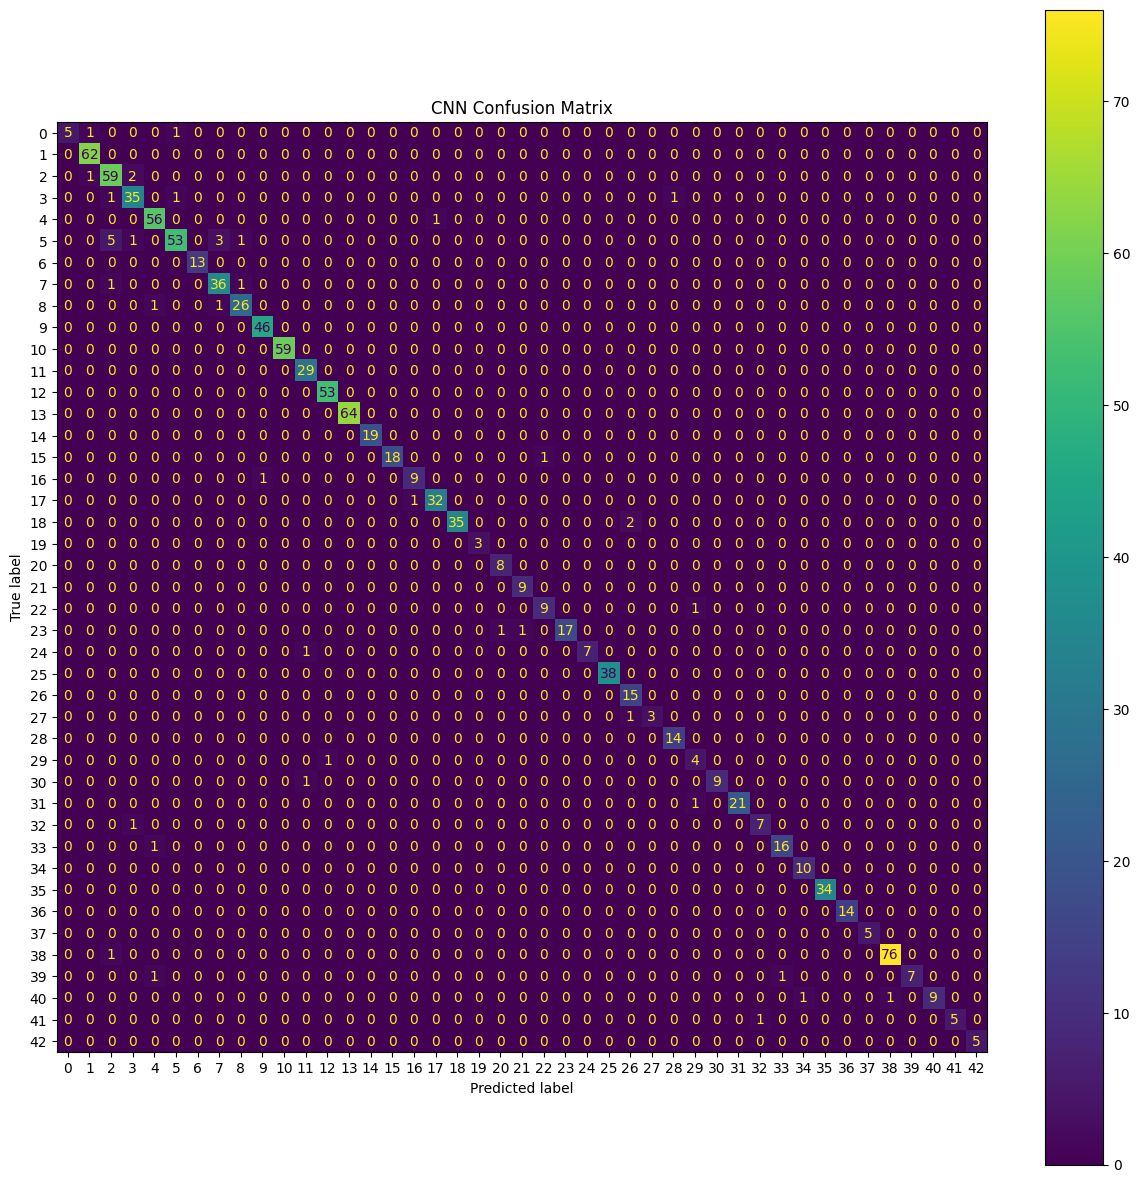

In [11]:
cm = confusion_matrix(np.argmax(y_test, axis=1), pred)
matrix = ConfusionMatrixDisplay(cm)
matrix.plot()
plt.gcf().set_size_inches(15, 15)
plt.title('CNN Confusion Matrix')
plt.show()

#### To predict on Kaggle Test Set

In [261]:
test_data = []
test_id = []

for i in range(len(test_paths)):
    try:
        # open image
        image = Image.open(f"Data/test/{test_paths.iloc[i]}")
        # resize image to (50, 50)
        image = image.resize(rescale_size)
        image = np.array(image)
        test_data.append(image)
        test_id.append(test_index.iloc[i])
    except:
        print(f"error loading image {test_paths.iloc[i]}")

test_data = np.array(test_data)

print(test_data.shape)
print(test_id)


(2353, 50, 50, 3)
[661, 4477, 1046, 631, 6533, 2899, 1941, 5749, 588, 1333, 5826, 7493, 4306, 3429, 1191, 4076, 1601, 2183, 4214, 5366, 5434, 6709, 2421, 4247, 5722, 1115, 1730, 6673, 156, 2011, 4416, 4661, 6511, 4411, 821, 6246, 3934, 5711, 3233, 3738, 4561, 3780, 6288, 3115, 7155, 7603, 1932, 6387, 6001, 4376, 2393, 5025, 660, 7634, 1978, 2398, 2826, 2679, 1466, 1953, 3887, 5681, 2945, 2481, 6552, 6096, 1969, 5544, 133, 2313, 5148, 3875, 1050, 960, 721, 2129, 6395, 4106, 1809, 1882, 6491, 7103, 2490, 2810, 3378, 2922, 269, 4468, 1162, 6523, 2106, 5505, 3292, 6605, 3836, 1188, 5752, 2627, 3829, 3616, 1085, 214, 5685, 5261, 879, 4070, 5183, 459, 5777, 4532, 3973, 6037, 2278, 2687, 1388, 6664, 966, 731, 1808, 7703, 5302, 5622, 2637, 5146, 3617, 5720, 5260, 7490, 2428, 7268, 6915, 5690, 6363, 3527, 4800, 1167, 3993, 93, 7816, 1116, 6634, 6411, 6616, 6299, 1866, 7400, 4527, 1528, 7801, 218, 3487, 6009, 1686, 4248, 5258, 3236, 5489, 6993, 6925, 3221, 7668, 4051, 4200, 5321, 5835, 3305, 562

In [262]:
# predict classes of test data
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(test_data), axis=-1)

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [263]:
result = pd.DataFrame({'id': test_index, 'ClassId': pred})
result.to_csv("results.csv", index=False)